In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [316]:
data = pd.read_csv(r'Senior DA task.csv')
data.describe()

,ORGANIZATION_ID,ACTIVITY_NAME,TIMESTAMP,CONVERTED,CONVERTED_AT,TRIAL_START,TRIAL_END
count,170526,170526,170526,170526,34235,170526,170526
unique,966,28,99738,2,206,966,966
top,33f0b98a557961f5ccc519bb972d450f,Scheduling.Shift.Created,2024-03-11 13:25:12.000,False,2024-04-04 15:25:04.000,2024-03-20 11:01:59.000,2024-04-19 11:01:59.000
freq,12136,96895,512,136291,3826,12136,12136


In [317]:
# Check if there are arganisations with ambiguous assigned Converted flag
mixed_conversion_orgs = data.groupby('ORGANIZATION_ID')['CONVERTED'].nunique()
mixed_conversion_orgs = mixed_conversion_orgs[mixed_conversion_orgs > 1]
mixed_conversion_orgs

Series([], Name: CONVERTED, dtype: int64)

In [318]:
# Check if there are duplicates
sum(data.duplicated())

67631

In [319]:
# Investigate duplicates
data[data.duplicated()]

,ORGANIZATION_ID,ACTIVITY_NAME,TIMESTAMP,CONVERTED,CONVERTED_AT,TRIAL_START,TRIAL_END
153,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-04-17 22:58:40.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
155,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-04-17 22:58:41.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
156,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.Created,2024-04-17 22:58:41.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
195,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.AssignmentChanged,2024-04-19 17:52:03.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
196,0040dd9ab132b92d5d04bc3acf14d2e2,Scheduling.Shift.AssignmentChanged,2024-04-19 17:52:03.000,False,NaN,2024-03-27 10:11:39.000,2024-04-26 10:11:39.000
...,...,...,...,...,...,...,...
170509,4eb736e6ff7851d301ae68a6aa37081a,Scheduling.Shift.Created,2024-01-25 09:53:33.000,False,NaN,2024-01-04 12:07:40.000,2024-02-03 12:07:40.000
170510,4eb736e6ff7851d301ae68a6aa37081a,Scheduling.Shift.Created,2024-01-25 09:53:33.000,False,NaN,2024-01-04 12:07:40.000,2024-02-03 12:07:40.000
170511,4eb736e6ff7851d301ae68a6aa37081a,Scheduling.Shift.Created,2024-01-25 09:53:33.000,False,NaN,2024-01-04 12:07:40.000,2024-02-03 12:07:40.000
170512,4eb736e6ff7851d301ae68a6aa37081a,Scheduling.Shift.Created,2024-01-25 09:53:33.000,False,NaN,2024-01-04 12:07:40.000,2024-02-03 12:07:40.000


In [320]:
# Let's drop them
data = data.drop_duplicates()

In [321]:
# Filter out activities which happened after conversion
data = data[(data['TIMESTAMP'] < data['CONVERTED_AT']) | (~data['CONVERTED'])]

In [322]:
# Check if there are any activities which happened before trial started
data[data['TRIAL_START']>data['TIMESTAMP']]

,ORGANIZATION_ID,ACTIVITY_NAME,TIMESTAMP,CONVERTED,CONVERTED_AT,TRIAL_START,TRIAL_END


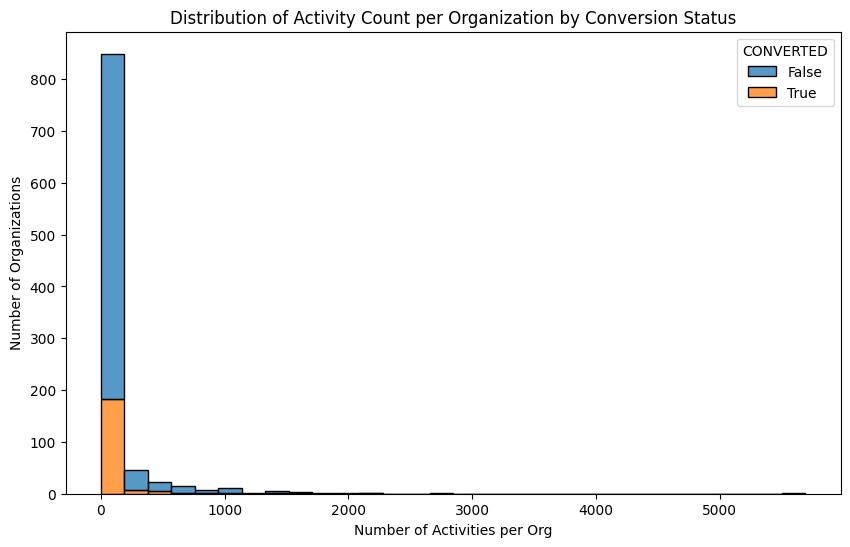

In [323]:
# Distribution of count of activities per org
activity_counts = data.groupby(['CONVERTED', 'ORGANIZATION_ID']).size().reset_index(name='ACTIVITY_COUNT')

plt.figure(figsize=(10, 6))
sns.histplot(data=activity_counts, x='ACTIVITY_COUNT', hue='CONVERTED', bins=30, kde=False, multiple='stack')

plt.title('Distribution of Activity Count per Organization by Conversion Status')
plt.xlabel('Number of Activities per Org')
plt.ylabel('Number of Organizations')
plt.show()

In [324]:
# Based on histagram, data seem to be significantly scewed, let's calculate scewness.
from scipy.stats import skew

print("Skewness:", skew(activity_counts['ACTIVITY_COUNT']))

Skewness: 7.885813836357933


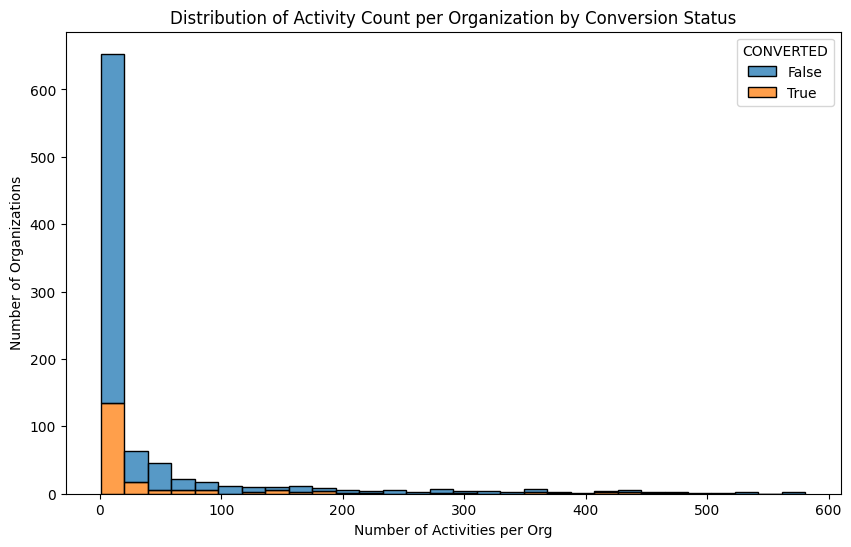

In [325]:
# Filter outliers
data = data.merge(activity_counts, on=['ORGANIZATION_ID', 'CONVERTED'])
upper_bound =  activity_counts['ACTIVITY_COUNT'].quantile(0.95)

# Filter out outliers
final_activity_data = data[data['ACTIVITY_COUNT'] <= upper_bound]

# Visualize distribution for filtered data
new_activity_counts = final_activity_data.groupby(['CONVERTED', 'ORGANIZATION_ID']).size().reset_index(name='ACTIVITY_COUNT')

plt.figure(figsize=(10, 6))
sns.histplot(data=new_activity_counts, x='ACTIVITY_COUNT', hue='CONVERTED', bins=30, kde=False, multiple='stack')

plt.title('Distribution of Activity Count per Organization by Conversion Status')
plt.xlabel('Number of Activities per Org')
plt.ylabel('Number of Organizations')
plt.show()

In [326]:
# Let's check skewness of the new dataset without outliers
print("Skewness:", skew(new_activity_counts['ACTIVITY_COUNT']))

Skewness: 3.147022092988748


In [327]:
final_activity_data.groupby('CONVERTED')['ORGANIZATION_ID'].nunique()

CONVERTED
False    721
True     197
Name: ORGANIZATION_ID, dtype: int64

In [328]:
# Mean and median number of activities per org in each converted category
new_activity_counts.groupby('CONVERTED').agg({
    'ACTIVITY_COUNT': ['mean', 'median']
})

ACTIVITY_COUNT       
                    mean median
CONVERTED                      
False          45.091540    7.0
True           47.020305    7.0

In [329]:
# Check how popular are activities
activity_metrics = final_activity_data.groupby(by = ['ACTIVITY_NAME', 'CONVERTED']).agg({
    'ORGANIZATION_ID': ['count', 'nunique']
})
activity_metrics.columns = ['NB_ACTIVITIES', 'NB_ORGANIZATIONS']
activity_metrics = activity_metrics.reset_index()
activity_metrics['AVG_ACTIVITIES_PER_ORG'] = activity_metrics['NB_ACTIVITIES'] / activity_metrics['NB_ORGANIZATIONS']
activity_metrics

,ACTIVITY_NAME,CONVERTED,NB_ACTIVITIES,NB_ORGANIZATIONS,AVG_ACTIVITIES_PER_ORG
0,Absence.Request.Approved,False,33,15,2.200000
1,Absence.Request.Approved,True,45,5,9.000000
2,Absence.Request.Created,False,46,17,2.705882
3,Absence.Request.Created,True,53,6,8.833333
4,Absence.Request.Rejected,False,4,3,1.333333
5,Absence.Request.Rejected,True,3,2,1.500000
6,Break.Activate.Finished,False,2,2,1.000000
7,Break.Activate.Finished,True,30,1,30.000000
8,Break.Activate.Started,False,2,2,1.000000
9,Break.Activate.Started,True,29,1,29.000000


In [330]:
# Compare how differently the product is used in converted and non converted organisations
pivoted = activity_metrics.pivot(
    index='ACTIVITY_NAME',
    columns='CONVERTED',
    values=['NB_ACTIVITIES', 'NB_ORGANIZATIONS', 'AVG_ACTIVITIES_PER_ORG']
)
pivoted.columns = [f"{col}_{'CONVERTED' if conv  else 'NOT_CONVERTED'}" for col, conv in pivoted.columns]
pivoted = pivoted.reset_index().fillna(0)
pivoted['IS_AVG_HIGHER_IN_CONVERTED'] = pivoted['AVG_ACTIVITIES_PER_ORG_CONVERTED'] > pivoted['AVG_ACTIVITIES_PER_ORG_NOT_CONVERTED']

In [331]:
# Select features that are both popular and have enough data for meaningful analysis.
# Specifically, we require each activity to be used by at least 30 organizations, including a minimum of 10 converted and 10 non-converted ones.
pivoted['IS_NUMBER_OF_ORGS_RELEVANT'] = (pivoted['NB_ORGANIZATIONS_NOT_CONVERTED']>=10) & (pivoted['NB_ORGANIZATIONS_CONVERTED']>=10) & (pivoted['NB_ORGANIZATIONS_NOT_CONVERTED'] + pivoted['NB_ORGANIZATIONS_CONVERTED']>=30)
activities_for_model = pivoted['ACTIVITY_NAME'][(pivoted['IS_NUMBER_OF_ORGS_RELEVANT'])].to_list()

### Prepare dataset

In [332]:
# Calculate day difference between activity and trial start date. Make format of all date columns recognized by Pandas as date
final_activity_data['TIMESTAMP'] = pd.to_datetime(final_activity_data['TIMESTAMP'])
final_activity_data['TRIAL_START'] = pd.to_datetime(final_activity_data['TRIAL_START'])
final_activity_data['TRIAL_END'] = pd.to_datetime(final_activity_data['TRIAL_START'])
final_activity_data['DAYS_SINCE_TRIAL_STARTED'] = (final_activity_data['TIMESTAMP'] - final_activity_data['TRIAL_START']).dt.days
final_activity_data['ACTIVITY_DATE'] = final_activity_data['TIMESTAMP'].dt.date
final_activity_data['CONVERTED_AT'] = pd.to_datetime(final_activity_data['CONVERTED_AT'], errors='coerce')
final_activity_data['DAYS_BETWEEN_TRIAL_STARTED_TO_CONVERSION'] = (final_activity_data['CONVERTED_AT'] - final_activity_data['TRIAL_START']).dt.days

# Define functions that return the number of activities completed within 3, 7, and 14 days of trial start
def count_activities_within_days(data, nb_days):
    return data[data['DAYS_SINCE_TRIAL_STARTED']<=nb_days].groupby(by='ORGANIZATION_ID').size()

def count_selected_activities_within_days(data, nb_days):
    return data[(data['DAYS_SINCE_TRIAL_STARTED']<=nb_days) & (data['ACTIVITY_NAME'].isin(activities_for_model))].groupby(by='ORGANIZATION_ID').size()

# Create `activity_features_days` by grouping data by organization_id and calculating activity-related metrics within defined timeframes.
activity_features_3d = count_activities_within_days(final_activity_data, 3).rename('nb_activities_3d')
activity_features_7d = count_activities_within_days(final_activity_data, 7).rename('nb_activities_7d')
activity_features_14d = count_activities_within_days(final_activity_data, 14).rename('nb_activities_14d')

activity_features_total = final_activity_data.groupby(by='ORGANIZATION_ID').size().rename('nb_activities_total')

selected_activity_features_3d = count_selected_activities_within_days(final_activity_data, 3).rename('nb_selected_activities_3d')
selected_activity_features_7d = count_selected_activities_within_days(final_activity_data, 7).rename('nb_selected_activities_7d')
selected_activity_features_14d = count_selected_activities_within_days(final_activity_data, 14).rename('nb_selected_activities_14d')

activity_features_days = pd.concat([activity_features_total, activity_features_14d, activity_features_7d, activity_features_3d, selected_activity_features_14d, selected_activity_features_7d, selected_activity_features_3d], axis = 1).fillna(0)
activity_features_days

C:\Users\komputer\AppData\Local\Temp\ipykernel_7224\2257990033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_activity_data['TIMESTAMP'] = pd.to_datetime(final_activity_data['TIMESTAMP'])
C:\Users\komputer\AppData\Local\Temp\ipykernel_7224\2257990033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_activity_data['TRIAL_START'] = pd.to_datetime(final_activity_data['TRIAL_START'])
C:\Users\komputer\AppData\Local\Temp\ipykernel_7224\2257990033.py:4: SettingWithCopyWarning: 
A value is tryin

,nb_activities_total,nb_activities_14d,nb_activities_7d,nb_activities_3d,nb_selected_activities_14d,nb_selected_activities_7d,nb_selected_activities_3d
ORGANIZATION_ID,,,,,,,
00456fd86311b6095ad05f7e31758f0d,6,6.0,6.0,6.0,6.0,6.0,6.0
007d48a2bc006e6eac0348c788d26dfd,5,5.0,5.0,5.0,5.0,5.0,5.0
00d6461845d0042b929379c263e9edef,2,2.0,0.0,0.0,2.0,0.0,0.0
00f00e783ff21fd62404d10ced5cd45f,6,6.0,6.0,6.0,6.0,6.0,6.0
014d8cdf08111d7442887a4704b47caa,14,14.0,14.0,14.0,14.0,14.0,14.0
...,...,...,...,...,...,...,...
4e44f506184abb41230dca9183e0dfde,92,92.0,72.0,60.0,92.0,72.0,60.0
4e76bb8e72c66ac1020407778635938f,137,137.0,137.0,137.0,137.0,137.0,137.0
4e7e4c7bd153b3e8728e7be9e717071b,7,7.0,7.0,7.0,7.0,7.0,7.0


In [333]:
# Define functions that return the number of active days in specified time window
def count_active_days_within_specified_timeframe(data, nb_days):
    active_days = data[['ORGANIZATION_ID', 'DAYS_SINCE_TRIAL_STARTED']].drop_duplicates()
    return active_days[active_days['DAYS_SINCE_TRIAL_STARTED']<nb_days].groupby(by='ORGANIZATION_ID').size()

activity_features_3d = count_active_days_within_specified_timeframe(final_activity_data, 3).rename('nb_active_days_3d')
activity_features_7d = count_active_days_within_specified_timeframe(final_activity_data, 7).rename('nb_active_days_7d')
activity_features_14d = count_active_days_within_specified_timeframe(final_activity_data, 14).rename('nb_active_days_14d')
activity_features_30d = count_active_days_within_specified_timeframe(final_activity_data, 30).rename('nb_active_days_30d')

# Combine all the previously defined time-related metrics
time_features = pd.concat([activity_features_days, activity_features_3d, activity_features_7d, activity_features_14d, activity_features_30d], axis = 1).fillna(0)

In [334]:
# Create final dataset which combines time-related and activity-related metrics on organisation level
activity_features_relevant_activities = final_activity_data[final_activity_data['ACTIVITY_NAME'].isin(activities_for_model)]
activity_features = activity_features_relevant_activities.pivot_table(
    index=['ORGANIZATION_ID', 'CONVERTED'],
    columns='ACTIVITY_NAME',
    aggfunc='size',
    fill_value=0
).reset_index()
final_data = activity_features.merge(time_features, how = 'left', on = 'ORGANIZATION_ID').fillna(0)
final_data

,ORGANIZATION_ID,CONVERTED,Communication.Message.Created,Mobile.Schedule.Loaded,PunchClock.PunchedIn,Scheduling.Shift.Approved,Scheduling.Shift.AssignmentChanged,Scheduling.Shift.Created,Scheduling.Template.ApplyModal.Applied,nb_activities_total,nb_activities_14d,nb_activities_7d,nb_activities_3d,nb_selected_activities_14d,nb_selected_activities_7d,nb_selected_activities_3d,nb_active_days_3d,nb_active_days_7d,nb_active_days_14d,nb_active_days_30d
0,00456fd86311b6095ad05f7e31758f0d,False,1,1,0,0,3,1,0,6,6.0,6.0,6.0,6.0,6.0,6.0,1.0,1.0,1.0,1
1,007d48a2bc006e6eac0348c788d26dfd,False,0,4,1,0,0,0,0,5,5.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,2
2,00d6461845d0042b929379c263e9edef,False,0,0,1,0,0,1,0,2,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1
3,00f00e783ff21fd62404d10ced5cd45f,False,0,0,0,0,2,4,0,6,6.0,6.0,6.0,6.0,6.0,6.0,1.0,1.0,1.0,1
4,014d8cdf08111d7442887a4704b47caa,False,0,0,0,0,5,9,0,14,14.0,14.0,14.0,14.0,14.0,14.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,4e44f506184abb41230dca9183e0dfde,True,0,64,4,1,0,23,0,92,92.0,72.0,60.0,92.0,72.0,60.0,3.0,5.0,7.0,7
911,4e76bb8e72c66ac1020407778635938f,False,0,0,0,41,3,93,0,137,137.0,137.0,137.0,137.0,137.0,137.0,1.0,1.0,1.0,1
912,4e7e4c7bd153b3e8728e7be9e717071b,False,0,0,0,0,0,7,0,7,7.0,7.0,7.0,7.0,7.0,7.0,1.0,1.0,1.0,1
913,4e900f739ad1a3cc11c0bc2ad85db6ff,False,0,0,0,0,0,84,0,84,84.0,84.0,84.0,84.0,84.0,84.0,1.0,1.0,1.0,1


In [403]:
# Random forest model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

X = final_data.iloc[:, 2:]
y = final_data.iloc[:, 1]

# Split dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = X_train.columns

# Construct model and run prediction
classifier = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_split=10, min_samples_leaf=5, max_features='sqrt', random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [404]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[149,   0],
       [ 34,   0]])

In [405]:
# Check accuracy for the training and test sets
print("Accuracy on training set: {:.2%}".format(classifier.score(X_train, y_train)))
print("Accuracy on test set: {:.2%}".format(classifier.score(X_test, y_test)))

Accuracy on training set: 78.69%
Accuracy on test set: 81.42%


In [406]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# Scores
print(f'Precision: {precision_score(y_test, y_pred, average=None)[0]:.2%}')
print(f'Recall: {recall_score(y_test, y_pred, average=None)[0]:.2%}')


Precision: 81.42%
Recall: 100.00%


C:\Users\komputer\planday-data-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


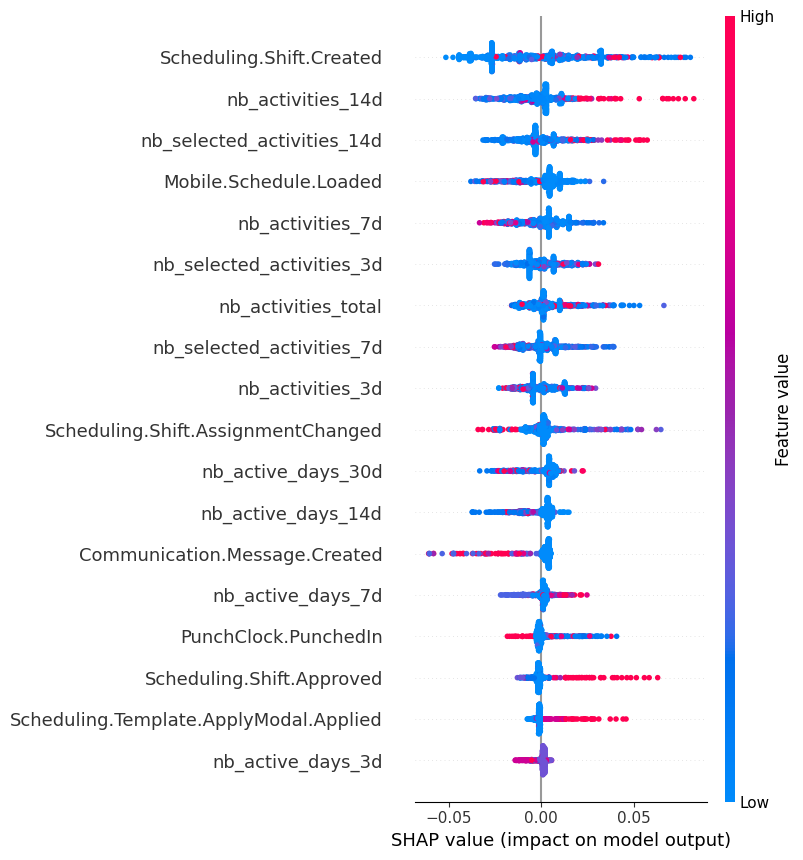

In [407]:
# Use SHAP (SHapley Additive exPlanations) to understand how each feature contributed to conversion.
import shap

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_train, approximate=False, check_additivity=False)

shap.summary_plot(shap_values[:, :, 1], X_train)

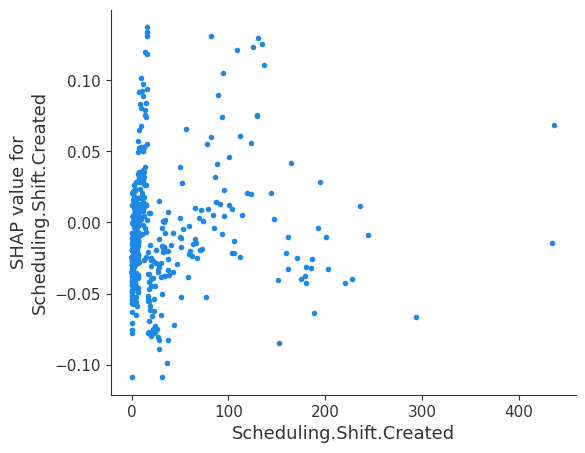

In [368]:
# Use SHAP dependency plot to explore trends and the distribution of model predictions, helping to understand how feature values influence the output
shap.dependence_plot('Scheduling.Shift.Created', shap_values[:,:,1], X_train, interaction_index=None)

<Axes: xlabel='CONVERTED', ylabel='Scheduling.Shift.Created'>

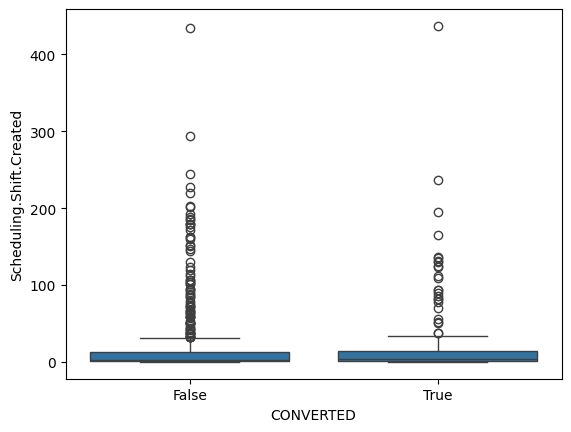

In [369]:
sns.boxplot(x=y_train, y=X_train['Scheduling.Shift.Created'])

There doesn’t seem to be a clear pattern between Scheduling.Shift.Created and the model’s predictions - higher values don’t consistently lead to higher SHAP values (i.e., a higher chance of conversion). Most of the points are clustered near zero, and the SHAP values themselves are quite small. So even though the feature is used in some tree splits, its overall impact on individual predictions is low. This means it’s not a strong driver of conversion and shouldn’t be used to define or guide any goals.

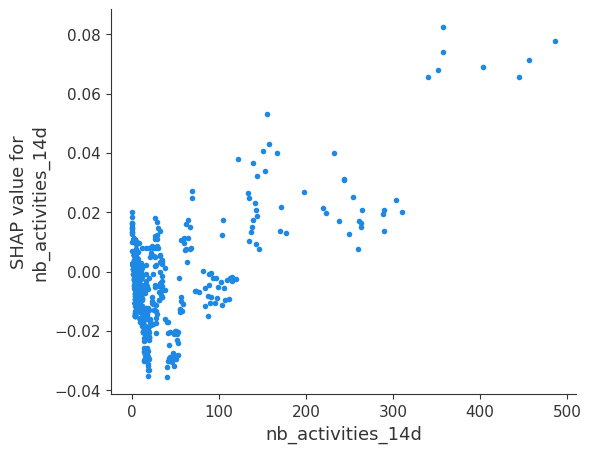

In [409]:
shap.dependence_plot('nb_activities_14d', shap_values[:,:,1], X_train, interaction_index=None)

Similarly, the number of activities performed within the first 14 days of the trial doesn't appear to be a strong indicator of conversion.

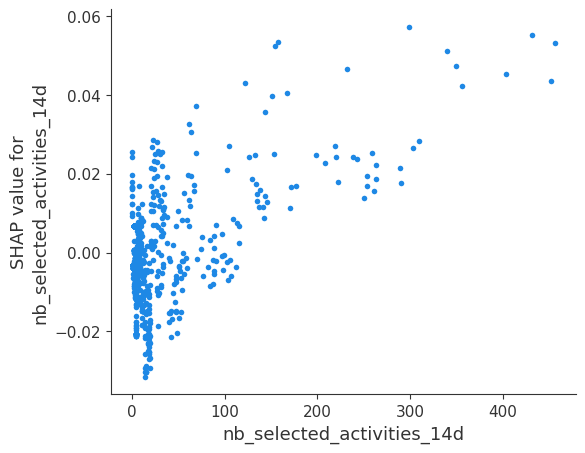

In [410]:
shap.dependence_plot('nb_selected_activities_14d', shap_values[:,:,1], X_train, interaction_index=None)

<Axes: xlabel='CONVERTED', ylabel='nb_selected_activities_14d'>

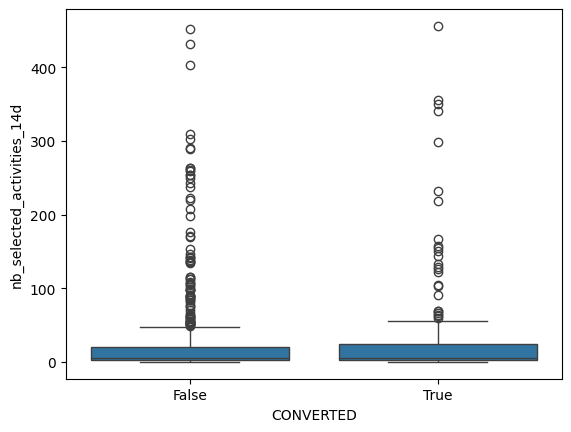

In [411]:
sns.boxplot(x=y_train, y=X_train['nb_selected_activities_14d'])

Although a higher number of activities classified as popular and relevant appears to be linked with higher conversion rates, the suggested cutoff — 70 activities — is quite high. In fact, it's about 10 times greater than the median number of activities completed within 30 days by organizations that did convert. Because of that, using such a high threshold as a goal wouldn't be practical.

From here on, I’ll focus on plotting features that show a clear pattern between their values and conversion likelihood, as indicated by the SHAP summary plot.

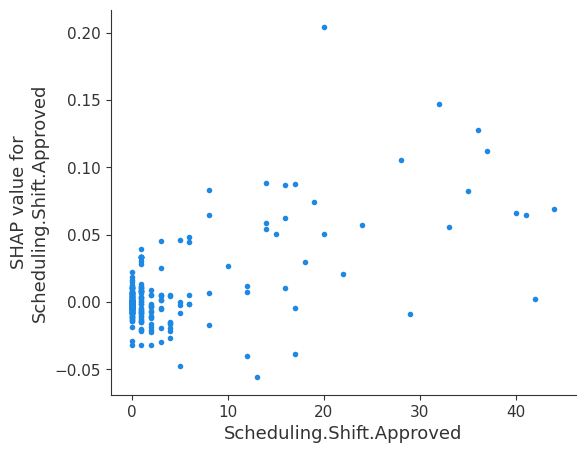

In [373]:
shap.dependence_plot('Scheduling.Shift.Approved', shap_values[:,:,1], X_train, interaction_index=None)

The dependence plot shows a trend: organizations reaching threshold of 5 Scheduling.Shift.Approved tend to have a much higher chance of converting. This makes it a strong candidate to define as a goal for driving engagement.

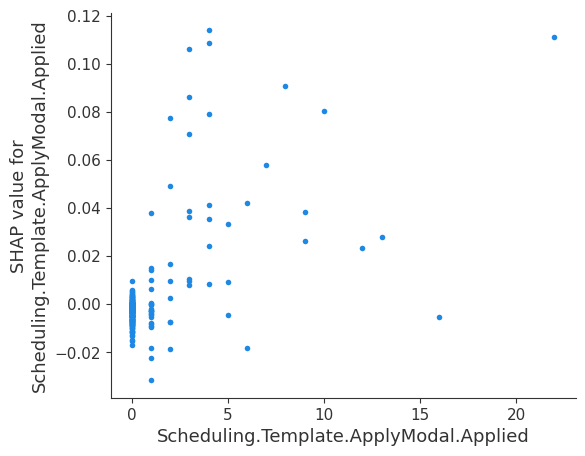

In [374]:
shap.dependence_plot('Scheduling.Template.ApplyModal.Applied', shap_values[:,:,1], X_train, interaction_index=None)

The dependence plot reveals a clear pattern: organizations that performed Scheduling.Template.ApplyModal.Applie activity more than twice are significantly more likely to convert. Based on this insight, it makes sense to use this threshold as a conversion-related goal.

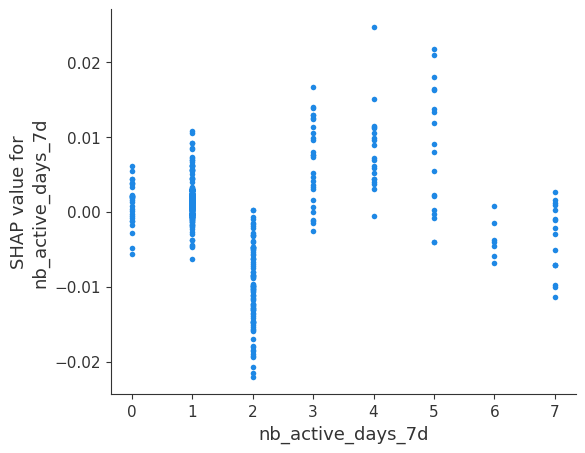

In [412]:
shap.dependence_plot('nb_active_days_7d', shap_values[:,:,1], X_train, interaction_index=None)

The dependence plot suggests that organisations which are active at least 3 days during 7 week of trial are more likely to convert. Therefore it can be the next goal.

## Descriptive Analysis & Product Metrics

In [349]:
org_count = final_data['ORGANIZATION_ID'].nunique()
print(f"Number of organizations included in analysis:", org_count)

Number of organizations included in analysis: 915


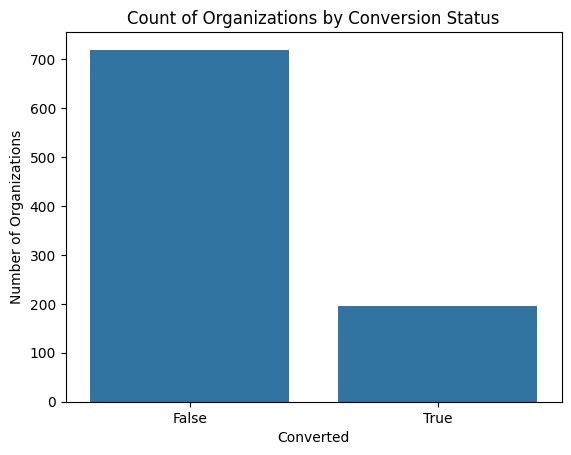

In [350]:
sns.countplot(x='CONVERTED', data=final_data)
plt.title('Count of Organizations by Conversion Status')
plt.ylabel('Number of Organizations')
plt.xlabel('Converted')
plt.show()

In [351]:
conversion_rate = final_data['CONVERTED'].mean()
print(f'Conversion rate: {conversion_rate:.2%}')

Conversion rate: 21.42%


In [352]:
conversion_dates = final_activity_data[['CONVERTED_AT', 'TRIAL_START', 'ORGANIZATION_ID']].drop_duplicates()
average_time_to_convert = (conversion_dates['CONVERTED_AT'] - conversion_dates['TRIAL_START']).dt.days.mean()
print(f'Average number of days to conversion: {average_time_to_convert:.2f}')

Average number of days to conversion: 30.30


In [353]:
# For activities distribution I will use pivoted data created in data exploratory phase
pivoted['NB_ACTIVITIES'] = pivoted['NB_ACTIVITIES_NOT_CONVERTED'] + pivoted['NB_ACTIVITIES_CONVERTED']
pivoted['NB_ORGANIZATIONS'] = pivoted['NB_ORGANIZATIONS_NOT_CONVERTED'] + pivoted['NB_ORGANIZATIONS_CONVERTED']
pivoted['%_OF_ALL_ORGANIZATIONS'] = pivoted['NB_ORGANIZATIONS']/final_data['ORGANIZATION_ID'].nunique()
pivoted = pivoted[['ACTIVITY_NAME',
         'NB_ORGANIZATIONS', 
         'NB_ORGANIZATIONS_CONVERTED', 
         '%_OF_ALL_ORGANIZATIONS', 
         'AVG_ACTIVITIES_PER_ORG_CONVERTED', 
         'AVG_ACTIVITIES_PER_ORG_NOT_CONVERTED',
         'IS_NUMBER_OF_ORGS_RELEVANT']]
pivoted.sort_values(by = 'NB_ORGANIZATIONS', ascending = False)

,ACTIVITY_NAME,NB_ORGANIZATIONS,NB_ORGANIZATIONS_CONVERTED,%_OF_ALL_ORGANIZATIONS,AVG_ACTIVITIES_PER_ORG_CONVERTED,AVG_ACTIVITIES_PER_ORG_NOT_CONVERTED,IS_NUMBER_OF_ORGS_RELEVANT
19,Scheduling.Shift.Created,800.0,176.0,0.874317,25.534091,23.932692,True
7,Mobile.Schedule.Loaded,408.0,88.0,0.445902,33.568182,34.509375,True
18,Scheduling.Shift.AssignmentChanged,296.0,64.0,0.323497,10.437500,11.771552,True
9,PunchClock.PunchedIn,165.0,39.0,0.180328,7.743590,10.746032,True
17,Scheduling.Shift.Approved,162.0,38.0,0.177049,9.842105,6.661290,True
5,Communication.Message.Created,108.0,17.0,0.118033,3.647059,5.263736,True
23,Scheduling.Template.ApplyModal.Applied,87.0,23.0,0.095082,4.391304,3.484375,True
14,Scheduling.Availability.Set,36.0,7.0,0.039344,3.571429,10.275862,False
16,Scheduling.OpenShiftRequest.Created,29.0,7.0,0.031694,1.142857,4.000000,False
25,ShiftDetails.View.Opened,24.0,4.0,0.026230,25.000000,11.650000,False


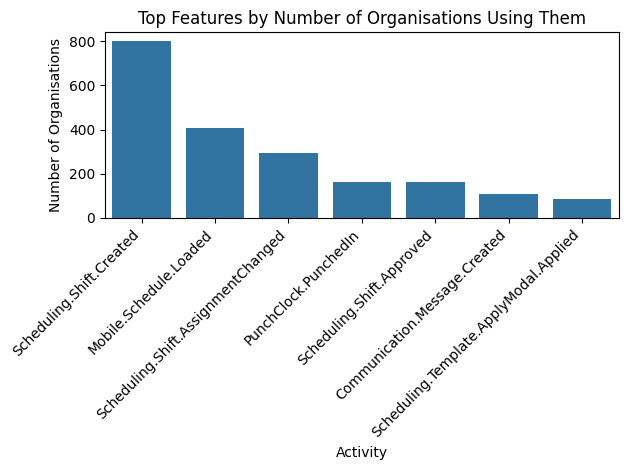

In [354]:
sorted_data = pivoted[pivoted['IS_NUMBER_OF_ORGS_RELEVANT']].sort_values('NB_ORGANIZATIONS', ascending=False)

# Create the barplot
sns.barplot(x="ACTIVITY_NAME", y="NB_ORGANIZATIONS", data=sorted_data)

# Titles and labels
plt.title("Top Features by Number of Organisations Using Them")
plt.xlabel("Activity")
plt.ylabel("Number of Organisations")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Optional: ensures labels fit into the figure area
plt.show()


Popular Activities and Their Relationship to Conversion
Among all activities, only 8 are used by at least 30 organizations, qualifying them for analysis. Of these, 7 activities are used by both 10+ converted and 10+ non-converted organizations and are marked with the flag IS_NUMBER_OF_ORGS_RELEVANT = True.

The most widely used feature is Scheduling.Shift.Created, used by 87% of organizations.

Mobile.Schedule.Loaded (45%) and Scheduling.Shift.AssignmentChanged (33%) follow in popularity.

Despite high adoption, these top-used features do not appear to contribute significantly to conversion.

In contrast, Scheduling.Shift.Approved (used by 18% of orgs) and Scheduling.Template.ApplyModal.Applied (10%) are less popular but qualify for analysis and show a positive association with conversion. This suggests these features may be more impactful for driving trial activation.

The remaining activities are too rarely used to assess their influence on conversion reliably.

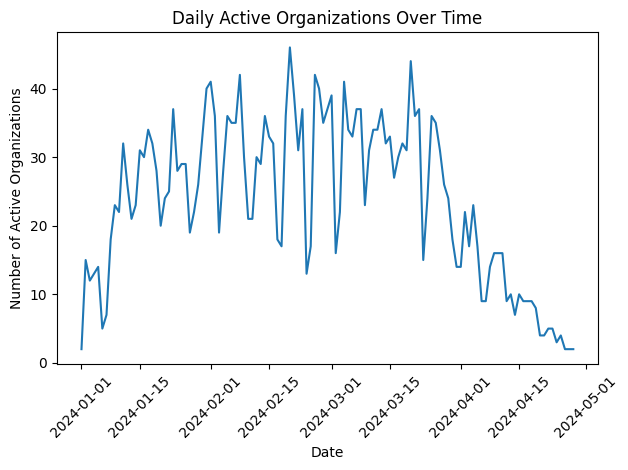

In [355]:
daily_active_orgs = final_activity_data.groupby('ACTIVITY_DATE')['ORGANIZATION_ID'].nunique().reset_index()
daily_active_orgs.columns = ['ACTIVITY_DATE', 'NB_ACTIVE_ORGS']

sns.lineplot(data=daily_active_orgs, x="ACTIVITY_DATE", y="NB_ACTIVE_ORGS")

plt.title("Daily Active Organizations Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Active Organizations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Analyzing daily activity among trial organizations reveals a few important trends. Engagement tends to start strong, with some fluctuation during the first week. However, we don't observe consistent weekly patterns that might suggest teams integrating the product into their regular workflows. Instead, there's a notable drop in activity that coincides with the typical end of the trial period.

This pattern points to a common trial behavior: many organizations explore the platform early on, but fail to maintain momentum beyond the initial period.

In [356]:
retention_data = final_activity_data.groupby('ORGANIZATION_ID')['DAYS_SINCE_TRIAL_STARTED'].max().reset_index()
retention_data.columns = ['ORGANIZATION_ID', 'MAX_DAYS_SINCE_TRIAL_STARTED']
retention_data['RETENTION_7D'] = retention_data['MAX_DAYS_SINCE_TRIAL_STARTED']>=7
retention_data['RETENTION_14D'] = retention_data['MAX_DAYS_SINCE_TRIAL_STARTED']>=14
retention_7d = retention_data['RETENTION_7D'].mean()
retention_14d = retention_data['RETENTION_14D'].mean()
print(f'7-day retention: {retention_7d:.2%}')
print(f'14-day retention: {retention_14d:.2%}')

7-day retention: 23.97%
14-day retention: 17.65%


Only about one in four organizations remain active after one week, and fewer than one in five after two weeks. These numbers highlight a clear opportunity to improve early user experience and help organizations understand the value of the product sooner.